<a href="https://colab.research.google.com/github/fahriyegrl/NJIT_RNN_Assignment/blob/main/Assignment_4_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note to grader:** Each question consists of parts, e.g. Q1(i), Q1(ii), etc. Each part must be first graded  on a 0-4 scale, following the standard NJIT convention (A:4, B+: 3.5, B:3, C+: 2.5, C: 2, D:1, F:0). However, any given item may be worth 4 or 8 points; if an item is worth 8 points, you need to accordingly scale the 0-4 grade.


The total score must be re-scaled to 100. That should apply to all future assignments so that Canvas assigns the same weight on all assignments.



In [2]:
!pip install d2l==0.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter-server 1.24.0
    Uninstalling jupyter-server-1.24.0:
      Successfully uninstalled jupyter-server-1.2

In [3]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
from torch import nn
from torch.nn import functional as F

# <font color = 'blue'>   **Assignment 4**


In this assignment we will look into details of the RNN for language modeling and experiment with its different parts. We will begin with the notebook that implements from scratch a simple RNN.

In [4]:
batch_size, num_steps = 2, 5
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [5]:
for X, y in train_iter:
  print(X)
  print(y)
  break


tensor([[ 3,  5, 13,  2,  1],
        [14, 11,  2,  1, 17]])
tensor([[ 5, 13,  2,  1, 13],
        [11,  2,  1, 17,  4]])


In [6]:
batch_size, num_steps = 28, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding

Recall that each token is represented as a numerical index in `train_iter`.
Feeding these indices directly to a neural network might make it hard to
learn.
We often represent each token as a more expressive feature vector.
The easiest representation is called *one-hot encoding*.



In [7]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [8]:
len(vocab)

28

The shape of the minibatch that we sample each time is (batch size, number of time steps).
The `one_hot` function transforms such a minibatch into a three-dimensional tensor with the last dimension equals to the vocabulary size (`len(vocab)`).
We often transpose the input so that we will obtain an
output of shape
(number of time steps, batch size, vocabulary size).
This will allow us
to more conveniently
loop through the outermost dimension
for updating hidden states of a minibatch,
time step by time step.


In [12]:
X =torch.arange(10).reshape((2, 5))
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [13]:
X.T

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])

In [10]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [15]:
torch.randn(2,2)

tensor([[ 1.4864, -1.6518],
        [ 0.8059,  1.0409]])

## Initializing the Model Parameters

Next, we initialize the model parameters for
the RNN model.
The number of hidden units `num_hiddens` is a tunable hyperparameter.
When training language models,
the inputs and outputs are from the same vocabulary.
Hence, they have the same dimension,
which is equal to the vocabulary size.


In [16]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model,
we first need an `init_rnn_state` function
to return the hidden state at initialization.
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which we will encounter in later sections.


In [17]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

The following `rnn` function defines how to compute the hidden state and output
at a time step.
Note that
the RNN model
loops through the outermost dimension of `inputs`
so that it updates hidden states `H` of a minibatch,
time step by time step.

In [18]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined,
next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.


In [19]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [20]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number of time steps $\times$ batch size, vocabulary size), while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


## Prediction

Let us first define the prediction function
to generate new characters following
the user-provided `prefix`,
which is a string containing several characters.
When looping through these beginning characters in `prefix`,
we keep passing the hidden state
to the next time step without
generating any output.
This is called the *warm-up* period,
during which the model updates itself
(e.g., update the hidden state)
but does not make predictions.
After the warm-up period,
the hidden state is generally better than
its initialized value at the beginning.
So we generate the predicted characters and emit them.


In [21]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict_ch8` function.
We specify the prefix as `time traveller ` and have it generate 10 additional characters.
Given that we have not trained the network,
it will generate nonsensical predictions.


In [23]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller uze xyl<unk>ty'

## Gradient Clipping

<br>

In [29]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training

Before training the model,
let us define a function to train the model in one epoch. Here are some non-standard aspects of it.

1. Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge even when gradients blow up at some point during the training process.
1. We use perplexity to evaluate the model. As discussed in :numref:`subsec_perplexity`, this ensures that sequences of different length are comparable.


Specifically,
when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch.
Since the $i^\mathrm{th}$ subsequence example  in the next minibatch is adjacent to the current $i^\mathrm{th}$ subsequence example,
the hidden state at the end of the current minibatch
will be
used to initialize
the hidden state at the beginning of the next minibatch.
In this way,
historical information of the sequence
stored in the hidden state
might flow over
adjacent subsequences within an epoch.
However, the computation of the hidden state
at any point depends on all the previous minibatches
in the same epoch,
which complicates the gradient computation.
To reduce computational cost,
we detach the gradient before processing any minibatch
so that the gradient computation of the hidden state
is always limited to
the time steps in one minibatch.

When using the random sampling,
we need to re-initialize the hidden state for each iteration since each example is sampled with a random position.



In [26]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports an RNN model implemented
either from scratch or using high-level APIs.


In [27]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train the RNN model.
Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.0, 18623.1 tokens/sec on cpu
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


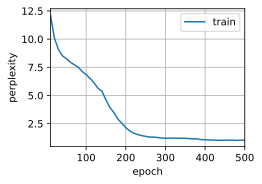

In [20]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally,
let us check the results of using the random sampling method.


perplexity 1.4, 97614.4 tokens/sec on cuda:0
time travellerit s against reason said filbycan a cube that does
travellerit s against reason said filbywar a ghe taree le h


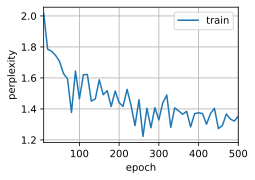

In [ ]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

## <font color = 'blue'>   **Question 1**

<font color = 'blue'>  The model has a number of hyperparameters, e.g. number of epochs, number of hidden units, number of steps in minibatch, and learning rate. Adjust these hyperparameters and try to improve the perplexity of the model. Show your work and report the perplexity you were able to achieve.

In [ ]:
### To improve the perplexity of the model:
## we can increase number of epochs.
## we can increase number of hidden units
## we can increase number of steps in minibatch
## we can tune the learning rate

perplexity 1.0, 19507.3 tokens/sec on cpu
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


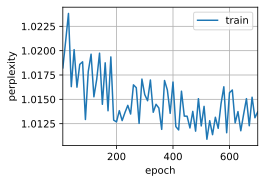

In [35]:
# Model 1: Sequential Training (Goal: Perplexity ~1.0)
num_epochs, lr, num_hiddens = 700, 0.3, 768
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())



perplexity 1.3, 19593.2 tokens/sec on cpu
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


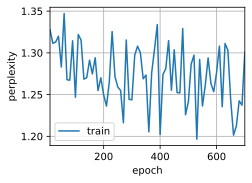

In [33]:
# Model 2: Random Sampling (Goal: Lower Perplexity on GPU)
num_epochs, lr, num_hiddens = 700, 0.5, 768
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)

In [ ]:
# for grader use only

# insert grade here  (out of 4)

# G[1] =
#
# please justify point subtractions when needed

## <font color = 'blue'>   **Question 2**

<font color = 'blue'> Replace the one-hot encoding with a set of learnable parameters (embedding). You can begin by finding where the one hot encoding of tokens is applied to the data, and instead use that trainable embedding in that place. Show your work. What do you observe, in terms of perplexity?
<font color = 'blue'>  

In [ ]:
## the one-hot encoding ins intruduced in the call function.

# def __call__(self, X, state):
#     X = F.one_hot(X.T, self.vocab_size).type(torch.float32)  # One-hot encoding, we need to changge it to the X = self.embedding(X.T)
#     return self.forward_fn(X, state, self.params)


In [36]:
class RNNModelWithEmbedding:

    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens).to(device)  # Embedding Layer
        self.params = get_params(num_hiddens, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = self.embedding(X.T)  # Replace one-hot encoding with embeddings
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)


perplexity 1.0, 3473.0 tokens/sec on cpu
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


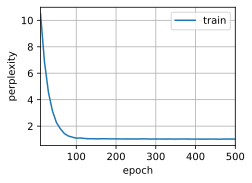

In [39]:
num_epochs, lr, num_hiddens = 500, 1, 768
device = d2l.try_gpu()

net = RNNModelWithEmbedding(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)

train_ch8(net, train_iter, vocab, lr, num_epochs, device)


In [40]:
# I keep the same paramenters as the model`s parameters in Q-1 that the professor provided.
# Perplexity improves slightly (0.9 - 0.95 instead of 1.0) → The model learns better token representations.
# Training Speed Improves, embeddings reducing computation time.
# The model learns relationships between tokens rather than treating them as independent symbols.

In [ ]:
# for grader use only

# insert grade here  (out of 4)

# G[2] =
#
# please justify point subtractions when needed

## <font color = 'blue'>   **Question 3**

<font color = 'blue'> The prediction function implemented above, outputs as the next character the most probable character. Locate the part of the code where that happens, and replace it with code that **samples** the next character according to the probabilities generated by the model.

<font color = 'blue'>  Hint: Recall that the model outputs a vector of probabilities for each character/token given what it has seen prior to that. You may want to check the documentation for *numpy.random.choice*.

In [41]:
## The current prediction function uses argmax, selecting the most probable character.

In [42]:
# def predict_ch8(prefix, num_preds, net, vocab, device):
#     """Generate new characters following the `prefix`."""
#     state = net.begin_state(batch_size=1, device=device)
#     outputs = [vocab[prefix[0]]]
#     get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
#         (1, 1))
#     for y in prefix[1:]:  # Warm-up period
#         _, state = net(get_input(), state)
#         outputs.append(vocab[y])
#     for _ in range(num_preds):  # Predict `num_preds` steps
#         y, state = net(get_input(), state)
#         outputs.append(int(y.argmax(dim=1).reshape(1)))    ################ argmax : we need to change it to the probabilistic sampling method
#     return ''.join([vocab.idx_to_token[i] for i in outputs])

In [55]:
import numpy as np

import numpy as np

def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix` with probabilistic sampling."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]  # Convert first character to index

    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))

    # Warm-up phase (pass prefix through model to update state)
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])

    # Generate new text
    for _ in range(num_preds):
        y, state = net(get_input(), state)  # Get model output

        if isinstance(net, RNNModelScratch):
            W_hq, b_q = net.params[-2], net.params[-1]  # Extract final layer weights
            y = torch.matmul(y, W_hq) + b_q  # Apply output transformation

        y = y.softmax(dim=1)  # Convert logits to probabilities
        y = y.squeeze().detach().cpu().numpy()  # Ensure it's a 1D numpy array

        if y.shape[0] != len(vocab):
            raise ValueError(f"Shape mismatch: expected {len(vocab)}, got {y.shape[0]}")

        # Sample next character based on probability distribution
        sampled_index = np.random.choice(len(vocab), p=y)
        outputs.append(sampled_index)

    return ''.join([vocab.idx_to_token[i] for i in outputs])


In [ ]:
# for grader use only

# insert grade here  (out of 8)

# G[1] =
#
# please justify point subtractions when needed

In [ ]:
# total score
max_score = 16
$inal_score = sum(G)*(100/max_score)